In [59]:
import matplotlib.pyplot as plt
import random
import numpy as np

import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors
from matplotlib import ticker, cm
import pickle

from scipy.stats import gamma as Gamma
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import expon

import seaborn as sns

from scipy.special import kolmogorov, erf
from scipy.special import gamma, factorial
from scipy.optimize import minimize

% Case 1: fully synthetic case
Mdata = 1e3;
mu = 2; sigma = 1;
tau1 = exprnd(lognrnd(mu,sigma,1,Mdata));
figure(1), histogram(tau1,40,'binlimits',[0 100]);
title('Case 1: fully synthetic case');

% Q1: tau1 is now exactly ~Exp(logN(mu,sigma)). Given data tau1, can
% we find a good estimate lambda1 ~ logN(mu,sigma)?
%
% Partial answer:
% https://en.wikipedia.org/wiki/Exponential_distribution#Bayesian_inference

In [124]:
Mdata = 1000
mu = 2
sigma = 1
tau1 = np.zeros((1, Mdata))

lamda = lognorm(mu,sigma).rvs(size=(1,Mdata))

for i in range(Mdata):
    tau1[0,i] = expon(lamda[0,i]).rvs(size=1)

(0.0, 100.0)

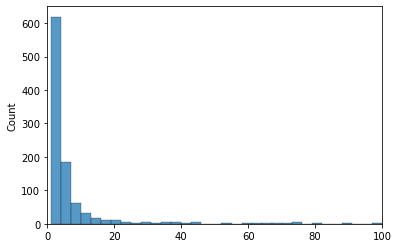

In [125]:
sns.histplot(tau1[0],  binwidth=3)
plt.xlim(0,100)

In [126]:
print("mean: ", np.mean(tau1))
print("std: ", np.std(tau1))

mean:  9.105836535338883
std:  26.623117894344833


Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

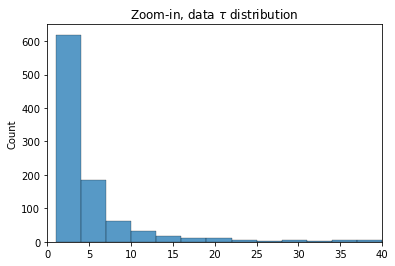

In [127]:
sns.histplot(tau1[0],  binwidth=3)
plt.xlim(0,40)
plt.title(r"Zoom-in, data $\tau$ distribution")

Text(0.5, 1.0, 'Parameters $\\lambda$ distribution')

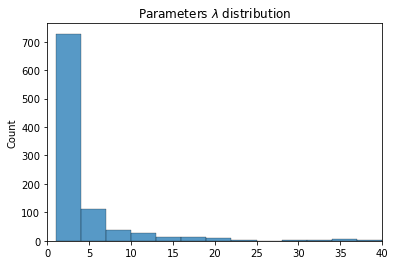

In [128]:
sns.histplot(lamda[0],  binwidth=3)
plt.xlim(0,40)
plt.title(r"Parameters $\lambda$ distribution")

In [129]:
print("mean: ", np.mean(lamda))
print("std: ", np.std(lamda))

mean:  8.083908109430968
std:  26.578415180270742


In [130]:
def Gamma_density(x, alpha, beta):
    p = beta**alpha/gamma(alpha)*(x**(alpha-1))*np.exp(-x*beta)
    return p

In [131]:
def LogLikelihood(params, data=[], func=Gamma_density):  
    alpha, beta = params
    l = np.sum(np.log(func(data, alpha, beta)))
    #print(l, params)
    return l

In [132]:
def Maximize_LogLikelihood(params, data=[], func=Gamma_density):
    return -LogLikelihood(params, data, func)

In [133]:
x0 = np.array([1, 1])
bnds = ((0.0001, 100), (0.0001, 100))
Estimates = minimize(Maximize_LogLikelihood, x0, args=(tau1),method='TNC', bounds=bnds, tol=1e-10)

In [135]:
alpha, beta = Estimates.x
mean_post = alpha/beta
 
print("alpha : ", alpha)
print("beta : ", beta)
print("Mean posterior : ", mean_post)

alpha :  0.717602089910514
beta :  0.07880682126946681
Mean posterior :  9.105837265746237


(0.0, 100.0)

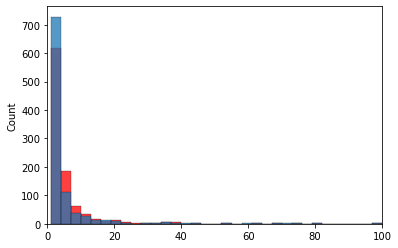

In [136]:
rv = Gamma(alpha, beta)
r = rv.rvs(size=1000)
#plt.hist(tau1[0], alpha=0.8)
sns.histplot(tau1[0],  binwidth=3, color = "r")
sns.histplot(lamda[0],  binwidth=3)


plt.xlim(0,100)